<h1><center> See The Cover, Buy The Book ? </center></h1>

<center> ADA Team Project - Fall 2017 </center>
<center> Nataljia Gucevska, Sébastien Chevalley, Alexis Montavon </center>

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import pickle
import json
import random
from scipy.cluster.hierarchy import fcluster,linkage
from scipy.sparse.csr import csr_matrix 

# Goal 

For this project, we set the very broad goal as following: finding insights about book cover and how they are related to their categories. Can we predirect the sales or the year of a book given its cover. Or is there any *book cover fashion* in the publishing industry.

## 1. Description of the Amazon dataset

We started this project by obtaining the Amazon dataset about books and their cover. The information on book covers are given as 4096 float vector representation computed from a Neural network. But most of the information contained about the books is pretty unrelevant for acheiving our goal. The brands and categories given are useless, the description and prices are sparse.

Examples on the amazon's website told us Metadata contained sales rank, categories and unique identifier. We quickly found out that for books, they were only one category: "Books" (and some of the records in the file were not in this category)

In [2]:
meta_book_df = pd.read_json('output.strict', lines=True)
meta_book_df.head()

,asin,brand,categories,description,imUrl,price,related,salesRank,title
0,0001048791,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51MKP0T4...,NaN,NaN,{'Books': 6334800},"The Crucible: Performed by Stuart Pankin, Jero..."
1,0001048775,NaN,[[Books]],William Shakespeare is widely regarded as the ...,http://ecx.images-amazon.com/images/I/5166EBHD...,NaN,NaN,{'Books': 13243226},Measure for Measure: Complete &amp; Unabridged
2,0001048236,NaN,[[Books]],"&#34;One thing is certain, Sherlockians, put a...",http://ecx.images-amazon.com/images/I/51DH145C...,9.26,"{'also_viewed': ['1442300191', '9626349786', '...",{'Books': 8973864},The Sherlock Holmes Audio Collection
3,0000401048,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41bchvIf...,NaN,{'also_viewed': ['068240103X']},{'Books': 6448843},The rogue of publishers' row;: Confessions of ...
4,0001019880,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/61LcHUdv...,5.39,"{'also_viewed': ['B003HMB5FC', '0834004593'], ...",{'Books': 9589258},Classic Soul Winner's New Testament Bible


We decided to enchance the important data we had (asin number, image url, sales information) with another dataset that could give us the publication date, language in the purpose of filtering and a some better categories. We turned to the [OpenLibrary](https://openlibrary.org) dataset to do so.

We are going to use the sales information in order to study the popularity of a book instead of the user reviews, to start at least. But we still have this dataset and it can be match with the asin number easily if we choose to use it later on. We think is is a good idea to start because: 1. we think that once we cluster books into their respective categories, they may be a clearer rank indicator than reviews 2. it is easier to get started without having ot join reviews.

We picked OpenLibrary as a source because we found out that using the API provided by Amazon to get metadata about a book is very rate-limited (less than 10k requests a day) and we have more than 2M books. Even with 1M books, around 5 differents IPs address, it would still take twenty days, more than the time we would have. Plus, OpenLibrary provides dump

## 2. Description of the OpenLibrary dataset

Size: 26.3 GB

Here is the information given for a book in this dataset. We have the language, the publication date, multiple type of identifiers to match both dataset (more about this in the next part) and different subjects as well as two classifiers, the [Library of Congress Classification](https://en.wikipedia.org/wiki/Library_of_Congress_Classification) and the [Dewey Decimal Classification](https://en.wikipedia.org/wiki/Dewey_Decimal_Classification).

In [3]:
num = 0
with open("ol_dump_editions_latest.txt", "r") as f:
    for l in f:
        book = json.loads(l.split("\t")[-1])
        print(book)
        break

{'publishers': ['Bernan Press'], 'physical_format': 'Hardcover', 'subtitle': '9th November - 3rd December, 1992', 'key': '/books/OL10000135M', 'title': 'Parliamentary Debates, House of Lords, Bound Volumes, 1992-93', 'identifiers': {'goodreads': ['6850240']}, 'isbn_13': ['9780107805401'], 'languages': [{'key': '/languages/eng'}], 'number_of_pages': 64, 'isbn_10': ['0107805405'], 'publish_date': 'December 1993', 'last_modified': {'type': '/type/datetime', 'value': '2010-04-24T17:54:01.503315'}, 'authors': [{'key': '/authors/OL2645777A'}], 'latest_revision': 4, 'works': [{'key': '/works/OL7925046W'}], 'type': {'key': '/type/edition'}, 'subjects': ['Government - Comparative', 'Politics / Current Events'], 'revision': 4}


Here is all the possible keys available for a book. We found duplicates and spelling mistakes. The key takeaway here is that the database quality is overall good because when we spent time to add the missing fields or the mispelled field we always added less than ten thousands records over a million.

In [17]:
{'author_names', 'authors', 'birth_date', 'body', 'bookweight', 'by_statement', 'by_statements', 'classifications', 'code', 'collections', 'contributions', 'contributors', 'copyright_date', 'coverid', 'coverimage', 'covers', 'create', 'created', 'description', 'dewey_decimal_class', 'dewry_decimal_class', 'dimensions', 'download_url', 'edition', 'edition_name', 'first_sentence', 'full_title', 'genres', 'ia_box_id', 'ia_id', 'ia_loaded_id', 'identifiers', 'isbn', 'isbn_10', 'isbn_13', 'isbn_invalid', 'isbn_odd_length', 'key', 'language', 'language_code', 'languages', 'last_modified', 'latest_revision', 'lc_classification', 'lc_classifications', 'lccn', 'library_of_congress_name', 'links', 'location', 'm', 'macro', 'name', 'news', 'notes', 'number_of_pages', 'numer_of_pages', 'ocaid', 'oclc_number', 'oclc_numbers', 'openlibrary', 'original_isbn', 'other_titles', 'pagination', 'physical_dimensions', 'physical_format', 'price', 'publish_country', 'publish_date', 'publish_places', 'publishers', 'purchase_url', 'remote_ids', 'revision', 'scan_on_demand', 'scan_records', 'series', 'source_records', 'stats', 'subject_people', 'subject_place', 'subject_places', 'subject_time', 'subject_times', 'subjects', 'subtitle', 'table_of_contents', 'title', 'title_prefix', 'translated_from', 'translation_of', 'type', 'uri_descriptions', 'uris', 'url', 'volume_number', 'volumes', 'vorks', 'weight', 'work_title', 'work_titles', 'works'}

{'author_names',
 'authors',
 'birth_date',
 'body',
 'bookweight',
 'by_statement',
 'by_statements',
 'classifications',
 'code',
 'collections',
 'contributions',
 'contributors',
 'copyright_date',
 'coverid',
 'coverimage',
 'covers',
 'create',
 'created',
 'description',
 'dewey_decimal_class',
 'dewry_decimal_class',
 'dimensions',
 'download_url',
 'edition',
 'edition_name',
 'first_sentence',
 'full_title',
 'genres',
 'ia_box_id',
 'ia_id',
 'ia_loaded_id',
 'identifiers',
 'isbn',
 'isbn_10',
 'isbn_13',
 'isbn_invalid',
 'isbn_odd_length',
 'key',
 'language',
 'language_code',
 'languages',
 'last_modified',
 'latest_revision',
 'lc_classification',
 'lc_classifications',
 'lccn',
 'library_of_congress_name',
 'links',
 'location',
 'm',
 'macro',
 'name',
 'news',
 'notes',
 'number_of_pages',
 'numer_of_pages',
 'ocaid',
 'oclc_number',
 'oclc_numbers',
 'openlibrary',
 'original_isbn',
 'other_titles',
 'pagination',
 'physical_dimensions',
 'physical_format',
 'price

There is also a key `identifiers` which is used to store various kind of identification in addition of ISBN. We found in it an Amazon field which could contains from Amazon identifiers to URL. Extracting them took times but was not usefull (added less than 400 books in the next step). This field identifiers contained less than 200 unique kinds of identifiers.

## 3. Matching the datasets

So we needed to match Amazon data with ASIN and OpenLibrary data which container various kind of identifiers (including some Amazon identifiers)

We found out that ASIN (Amazon product identifier) is in fact ISBN-10 for books. We first tried to match data based on this information. We also tried to extract amazon identifier from other field in the OpenLibrary dataset but only found less than 5'000 new records to add.

We removed data from the Amazon dataset where we have no sales ranking data because we want to be able to compare popularity or if there is is no link to the image cover as we want to compare visually the similarity. Most of the removal (less than 500'000 records) are dropped because of missing sales ranking information.

From the OpenLibrary dataset we removed the records if there is no ISBN, language, date or topics. Language because we expect to keep only English books because of cultural difference (what is trendy in English-speaking field is not what is treandy in other languages, we think there is some boundaries because of language). Also, we removed records because of publish dates because we have temporal bias to take in account and we want to be able to filter at least by year and see if there exists different trends in different times. Altough we could fill the hole for the language, date or topics (by scraping other website or amazon itself), ISBN is mandatorsy since its purpose is primary key to do the join operation. Other field could be filled up later if our dataset is too narrow.

## In practice

* We first tried different option to join the datasets. One key point for our exploratory analysis was to to be **lean**. * Very firstly we tried to import both dataset as dataframe, but it took way too much for the 32GB main memory machine we had access to.
* But for our next experiments we first exported the set of ASIN of the Amazon dataset (~47MB) and then tried various solution to extract identifiers from the OpenLibrary dataset
    * First one was fuzzy matching using "Amazon:" and "ISBN:" per-line grep search. It did not yield any significant results but allowed us to not parse the JSON
    * Second one was parsing the JSON and export Amazon identifiers we found out in the file, join result size was near 80'000 books matched. Not enough!
    * We found out during our research that ASIN were in fact ISBN and this time parsed the JSON and exported all ISBN (10, 13 and ASIN) from it. We got around 1 millions matches
* We implemented a script using the multiprocessing package from Python to read line from files and then using multiple workers to parse the JSON. Even on an spinning drive, without multiprocessing, the script was not IO-bound but CPU bound.
* Once we got better result and more responsive times we started to export other fields and did filtering as explained before

The matching has been done the following. Instead of reimplementing Panda's feature. We built two dataframes, one per dataset with the following columns:

* for Amazon dataset: 1. Row number in the file, 2. ASIN
* for OpenLibrary dataset: for each identifiers of a given book, 1. Row number in the file, 2. Identifier found

So we could have more than one row per book in the OpenLibrary Dataframe.

From that, we used the merge method from Pandas to join together both dataset. We when joined on each side remaining information and built a new dataset. We merged together data from OpenLibrary and tried to detect mismatch (two different languages or publish_date)

In [19]:
with open('merged_data.pickle', 'rb') as f:
    merged_data = pickle.load(f)
merged_df = pd.DataFrame(merged_data)
merged_df.head()

,asin,image_url,languages,publish_date,sales_rank,subjects
0,0000401048,http://ecx.images-amazon.com/images/I/41bchvIf...,[eng],1974,6448843.0,"[Publishers and publishing, United States]"
1,0001019880,http://ecx.images-amazon.com/images/I/61LcHUdv...,[eng],October 2000,9589258.0,"[Other Translations - General, Bibles, Bibles ..."
2,0001057170,http://ecx.images-amazon.com/images/I/51M65KR8...,[eng],"September 1, 2000",9318563.0,"[Humour, Humor, English, Audio Adult: Other, G..."
3,0001053396,http://ecx.images-amazon.com/images/I/51WTKK4V...,[eng],September 1999,12249714.0,"[Poetry texts & anthologies, Poetry, Abridged ..."
4,0001053744,http://ecx.images-amazon.com/images/I/712C-G3X...,[eng],"January 1, 2001",5665835.0,"[Works by individual poets: classical, early &..."


## 4. Insight about the data

### Publication dates

In [20]:
year_p = re.compile("[0-9]{4}")

# remove non 4 digits year in publish date (81 rows removed over 1.3M)
merged_df = merged_df[merged_df["publish_date"].map(lambda x: len(year_p.findall(x)) == 1)]
merged_df = merged_df[merged_df["languages"].map(lambda x: "eng" in x)]
merged_df["publish_date"] = merged_df["publish_date"].map(lambda x: int(year_p.findall(x)[0]))
merged_df["publish_date"].hist(bins=range(1900,2017), figsize=(16,7))
plt.plot(x=[2007,2007], y=[0,10000], linewidth=2, color="black")
plt.ylim((0,10000))
plt.show()

NameError: name 'black' is not defined

Pay attention how the data peak around 2007. It is not because books became not trendy and lost all the sales. No the reason is that in 2007, book publishers have transitioned from ISBN10 to EAN13. And we can see that in the data. Amazon still uses a ten digits identifiers and we know the formula to convert an ISBN10 code to an EAN13 but did not further investigate in this direction.

### Subjects

In [6]:
subjects_list = []
for subjects in merged_df["subjects"].values.tolist():
    for subject in subjects:
        subjects_list.append(subject)
frequencies = pd.Series(subjects_list).value_counts()

In [7]:
frequencies.shape

(597493,)

In [8]:
df_hist = pd.DataFrame(frequencies)
df_hist.columns = ["count"]
df_hist.head(n=100)

,count
General,109883
Fiction,102776
History,48923
Religion,40365
United States,31914
Juvenile Fiction,24352
Reference,23091
Protected DAISY,22791
Fiction - General,21782
Juvenile Nonfiction,21018


Since categories from subjects in the OpenLibrary dataset are very hard to read and so diverse (597'493), we chose to work with the Library of Congress classification and/or the Dewey classification. From now one we will drop the *subjects* information as it does not provide any information for us.

## 5. LC & Dewey classifications

As we said before we want to use a more general classification for our books the Library of Congress and Dewey Decimal classifications let us do so. Here are the categories for both of them:

In [9]:
lc_class = pd.read_csv('lcClassification.csv')
lc_class

,Letter,Subject area
0,A,General Works
1,B,"Philosophy, Psychology, and Religion"
2,C,Auxiliary Sciences of History
3,D,General and Old World History
4,E,History of America
5,F,"History of the United States and British, Dutc..."
6,G,"Geography, Anthropology, and Recreation"
7,H,Social Sciences
8,J,Political Science
9,K,Law


In [10]:
dewey_class = pd.read_csv('deweyClassification.csv', names=['Interval', 'Subject Area']).drop(0, axis=0)
dewey_class

,Interval,Subject Area
1,000,Computer science / information & general works
2,100,Philosophy & psychology
3,200,Religion
4,300,Social sciences
5,400,Language
6,500,Pure Science
7,600,Technology
8,700,Arts & recreation
9,800,Literature
10,900,History & geography


As the Library of Congress classification is a bit more detailed than the Dewey Decimal and there is more data with the first one, we selected this classification for our project. We will match this classification to the filtered dataset. In order to keep some coherence we will only take data entries that have the LoC classification. This is how our filtered and matched dataset looks like:

In [11]:
filtered_df = pd.read_pickle('filtered_merge_data.pickle')
filtered_df.head()

,asin,dewey,image_url,languages,lc,publish_date,sales_rank,category
40,0001837192,"{eng, 759.9493}",http://ecx.images-amazon.com/images/I/913JcEhB...,{eng},"{ND673.B74 C7 1975b, eng}",{1975},5555643.0,Fine Arts
48,0001839225,"{[E], eng}",http://ecx.images-amazon.com/images/I/61qIWAs9...,{eng},"{eng, PZ7.B25058 Sp 1995}","{1995, 1980}",738272.0,Language and Literature
55,0001714538,"{eng, 428.6}",http://ecx.images-amazon.com/images/I/A1zj84uC...,{eng},"{eng, PE1119}",{1985},1397256.0,Language and Literature
64,0001847775,{eng},http://ecx.images-amazon.com/images/I/51CGeo4B...,{eng},"{eng, PZ7.G18417 St}",{1976},13408595.0,Language and Literature
66,0001950584,"{746.44/20433/0942, eng}",http://ecx.images-amazon.com/images/I/61-4Su3Y...,{eng},"{NK3049.B3 D4 1988, eng}","{1984, 1988}",1019744.0,Fine Arts


## 6. Clustering by book cover 

We start our data analysis by clustering the books by cover. Using the data from library of congress and open library we can see if the books of specific categories appear in the same clusters. This will allow us to see if there is a link between the book categories and the covers.

Not knowing the number of clusters, we decided to use aglomerative clustestering. Also for this part, we decided to use small fraction of the available data before starting with deeper and longer analysis. 


### 6.1. Load data

In [2]:
with open('filtered_features.pickle', 'rb') as f:
    filtered_features = pickle.load(f)
    
with open('filtered_asins.pickle', 'rb') as f:
    filtered_asins = pickle.load(f)
    
with open('filtered_merge_data.pickle', 'rb') as f:
    category_data = pickle.load(f)

### 6.2. Choose samples to cluster

Here we keep the data that has category entry

In [3]:
asins = {}
set_asins = []
set_filtered_asins = set(filtered_asins)

for d, c in zip(category_data['asin'], category_data['category']): 
    if d in set_filtered_asins:
        asins[d] = c
        set_asins.append(d)


set_asins = set(set_asins)

In [4]:
features = []
a = []
category = []

for f_a, f in zip(filtered_asins, filtered_features):
    if(f_a in set_asins): 
        category.append(asins[f_a])
        a.append(f_a)
        features.append(f)

In [5]:
#print(count)
print(len(features))
print(len(a))
print(len(category))

128674
128674
128674


In [10]:
random_features = []
random_asins = []
random_category = []
for f, f_a, c in zip(features, a, category): 
    if random.randint(0,100) < 10: 
        random_features.append(f.tolist()[0])
        random_asins.append(f_a)
        random_category.append(c)

In [11]:
len(random_features)

12963

### 6.3. Cluster the chosen features

The clustering is done using aglomerative clustering and the number of clusters is not fixed. 

In [12]:
Z = linkage(random_features, "ward")

In [13]:
k=10
clusters = fcluster(Z, k, criterion='maxclust')

### Histogram with number of samples in each cluster

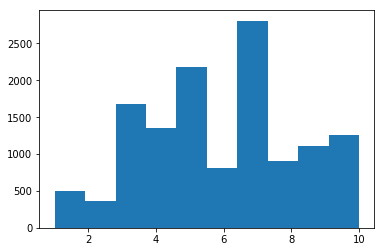

In [14]:
plt.hist(clusters)
plt.show()

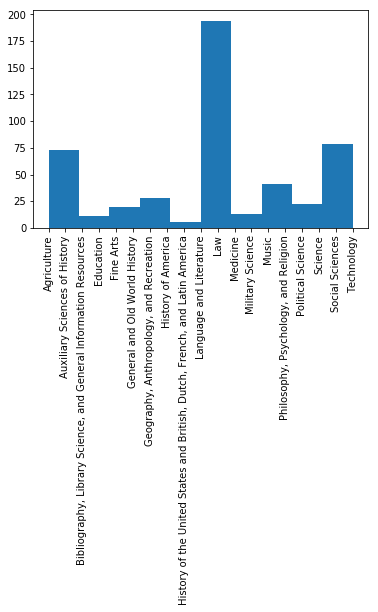

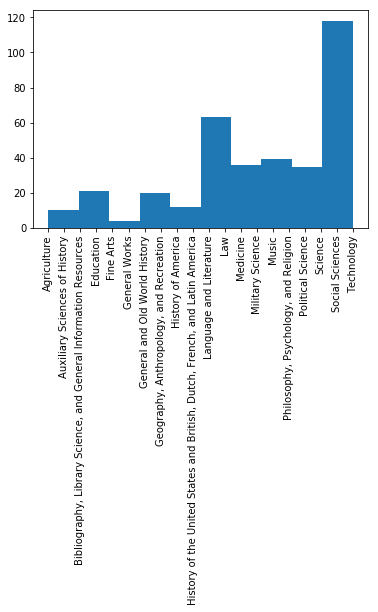

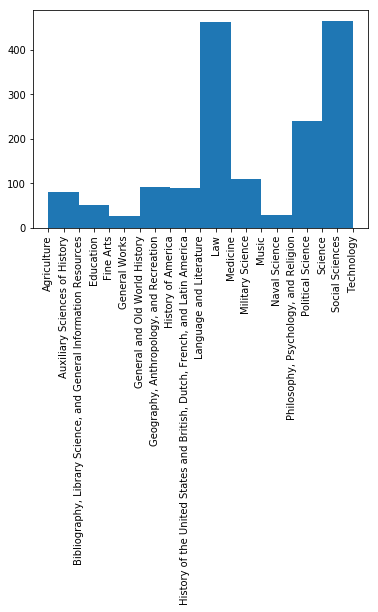

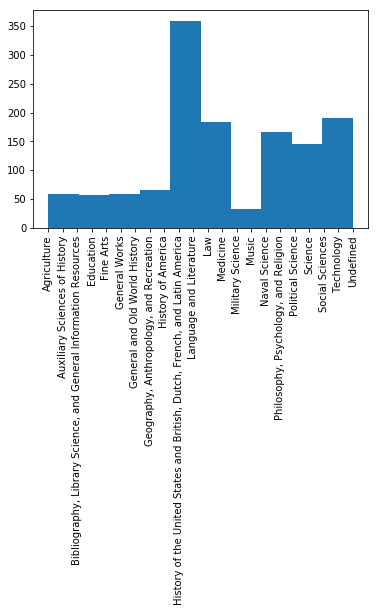

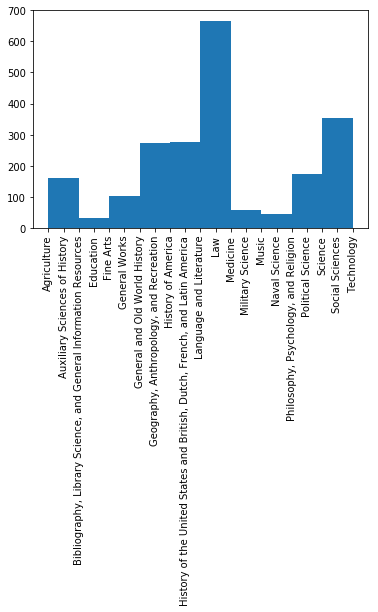

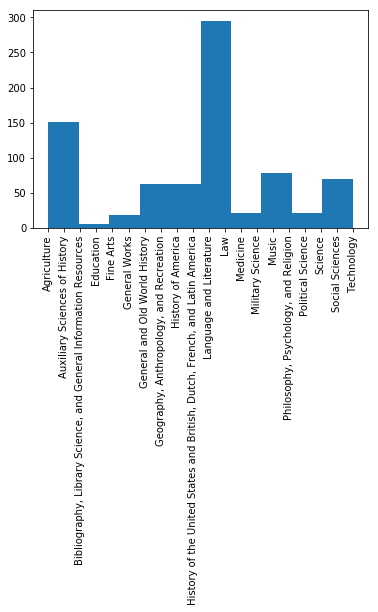

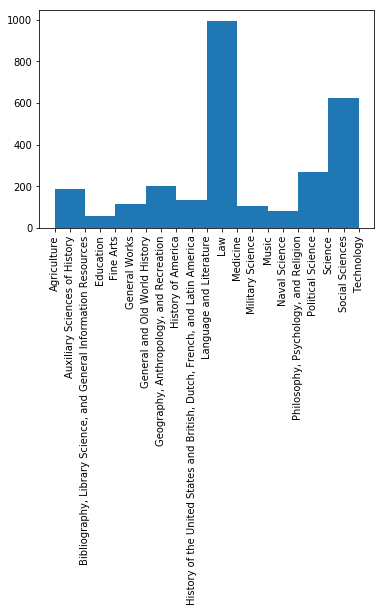

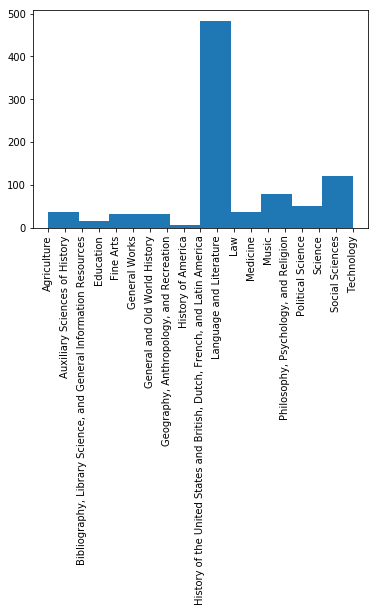

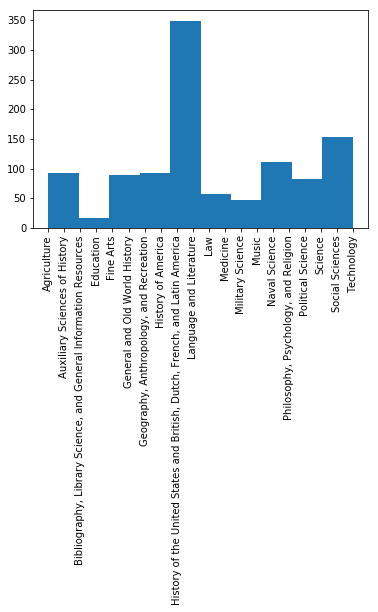

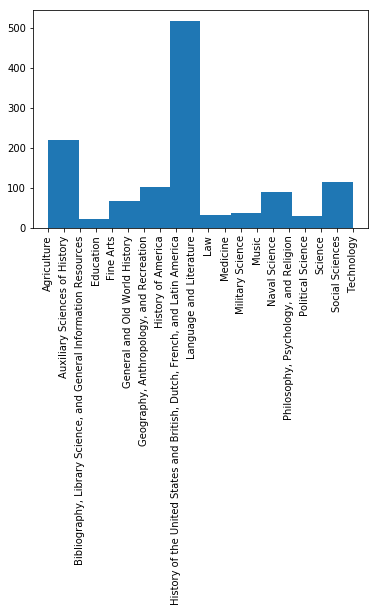

In [33]:
for c in range(1, k+1):
    categories = []
    for i, t in enumerate(clusters==c):
        if t and random_category[i] is not None:
            categories.append(random_category[i])
    plt.hist(categories)
    locs, labels = plt.xticks()
    plt.xticks(rotation='vertical')
    plt.show()

Here we cluster the images in 10 clusters and we show the presence of different categories in each cluster. We can clearly see that in each cluster there is one class that is significantly more present that the other classes in the cluster.  

This is an interesting observation that we will analyze with more data in the further steps of this project. 

# Next steps

### Data processing

1. Merge the ratings with the books that have a category classification 
2. Adapt the sales ranking for future analysis

### Data analysis 

3. Continue the analysis in point 6, and analyze if books with similar covers have similar ratings/sales
4. Analyze if there are trends, if yes how long is their duration